# Fine Tuning Experiments

## Dependencies Set-up

In [1]:
# --- Import Required Libraries ---
import os
import sys
import pandas as pd

# --- Set Up Paths ---
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT_PATH not in sys.path:
    sys.path.insert(0, ROOT_PATH)

# --- Import Custom Libraries ---
from pop.util.print_results import (
    print_statistics,
    plot_fitness_diversity,
    compare_best_fitness_diversity,
    plot_time_per_run,
    plot_fitness_distribution,
    plot_fitness_vs_time
)
from pop.util.fine_tuning import (
    select_configs,
    get_results_path,
    generate_base_filename,
    fine_tune_algorithms_parallel, 
    run_selected_configs_parallel
)

## Parameter Definition

In [2]:
# Number of runs for statistically significant results
num_runs = 5

# Experiment parameters (define these explicitly)
dataset = "../dataset"
num_companies = 200
risk_free_rate = 0.042
start_date = "2015-01-01"
end_date = "2020-01-01"
correlation_level = 'medium'
seed = 0

## Hyperparameter Configuration

In [3]:
# Hyperparameters for Genetic Algorithm (GA)
ga_param_grid = {
    "pop_size": [50, 100, 200],
    "mutation_rate": [0.01, 0.05, 0.1],
    "gaussian_stdev": [0.01, 0.05, 0.1],
    "num_elites": [1, 2, 5],
    "max_generations": [50, 100]
}

# Hyperparameters for Particle Swarm Optimization (PSO)
pso_param_grid = {
    "swarm_size": [50, 100, 200],
    "max_iterations": [50, 100],
    "w": [0.4, 0.7, 0.9],
    "c1": [1.0, 1.5, 2.0],
    "c2": [1.0, 1.5, 2.0]
}

# Possible repair methods
REPAIR_METHODS = ["normalize", "clip", "restart", "shrink"]

## Fine-Tuning Run

- Experimentation with different hyperparameters

In [ ]:
# Parallel fine-tuning for all configs
fine_tuning_results = fine_tune_algorithms_parallel(
    num_runs=5,
    dataset=dataset,
    num_companies=num_companies,
    risk_free_rate=risk_free_rate,
    start_date=start_date,
    end_date=end_date,
    correlation_level=correlation_level,
    seed=seed,
    ga_param_grid=ga_param_grid,
    pso_param_grid=pso_param_grid,
    repair_methods=REPAIR_METHODS
)

In [4]:
# If already available in separate files, load fine tuning results for GA and PSO
fetch_from_files = True

if fetch_from_files:
    ft_results_path_ga = "../experiments/results/ga/fine_tuning_results.csv"
    ft_results_path_pso = "../experiments/results/pso/fine_tuning_results.csv"
    fine_tuning_results_df_ga = pd.read_csv(ft_results_path_ga)
    fine_tuning_results_df_pso = pd.read_csv(ft_results_path_pso)

    ga_best, ga_median, ga_worst = select_configs(fine_tuning_results_df_ga, "GA")
    pso_best, pso_median, pso_worst = select_configs(fine_tuning_results_df_pso, "PSO")
else:
    # Select best, median, and worst configs for GA and PSO
    ga_best, ga_median, ga_worst = select_configs(pd.DataFrame(fine_tuning_results), "GA")
    pso_best, pso_median, pso_worst = select_configs(pd.DataFrame(fine_tuning_results), "PSO")

# Combine into a list
selected_configs = [ga_best, ga_median, ga_worst, pso_best, pso_median, pso_worst]

- Re-run best, median and worst configuratiosn for GA and PSO 

In [ ]:
# Run the selected configurations in parallel
final_results_df = run_selected_configs_parallel(
    selected_configs=selected_configs,
    num_runs=31,
    dataset=dataset,
    num_companies=num_companies,
    risk_free_rate=risk_free_rate,
    start_date=start_date,
    end_date=end_date,
    correlation_level=correlation_level,
    seed=seed
)

In [ ]:
# Save the final results to a CSV file
result_path = get_results_path("final_fine_tuning_results.csv")
final_results_df.to_csv(result_path, index=False)
print(f"✅ Final fine-tuning results saved to '{result_path}'")

In [5]:
# Load and print statistics
final_results_df = pd.read_csv(get_results_path("final_fine_tuning_results.csv"))
print_statistics(final_results_df, "sharpe_ratio")
print_statistics(final_results_df, "annual_return")
print_statistics(final_results_df, "runtime")


📊 Statistics for Sharpe_ratio across configurations:

🔍 Best Configuration:
  GA Sharpe_ratio:
count    31.000000
mean      0.776109
std       0.012611
min       0.742165
25%       0.769797
50%       0.774428
75%       0.785346
max       0.799252
Name: sharpe_ratio, dtype: float64
  PSO Sharpe_ratio:
count    31.000000
mean      0.865555
std       0.029963
min       0.788354
25%       0.847084
50%       0.868360
75%       0.885226
max       0.925617
Name: sharpe_ratio, dtype: float64

🔍 Median Configuration:
  GA Sharpe_ratio:
count    31.000000
mean      0.631249
std       0.022384
min       0.591797
25%       0.614238
50%       0.629411
75%       0.648509
max       0.677507
Name: sharpe_ratio, dtype: float64
  PSO Sharpe_ratio:
count    31.000000
mean      1.212843
std       0.046329
min       1.070491
25%       1.195341
50%       1.216931
75%       1.236060
max       1.305605
Name: sharpe_ratio, dtype: float64

🔍 Worst Configuration:
  GA Sharpe_ratio:
count    31.000000
mean      

## Visualization

### Fitness and Diversity Evolution (GA and PSO)

- Plot the evolution of fitness and diversity over generations for each algorithm
- Separate plots for GA and PSO
- Display best, median, and worst configurations in the same plot for comparison

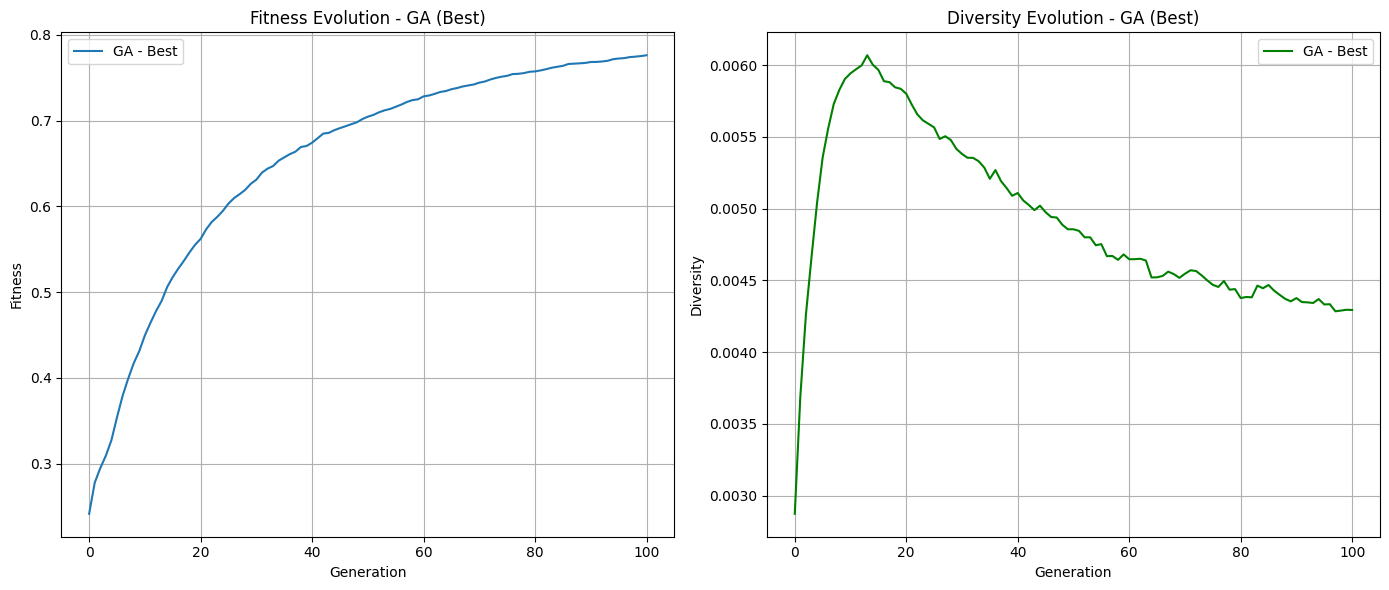

✅ Plotted fitness and diversity for GA - Best


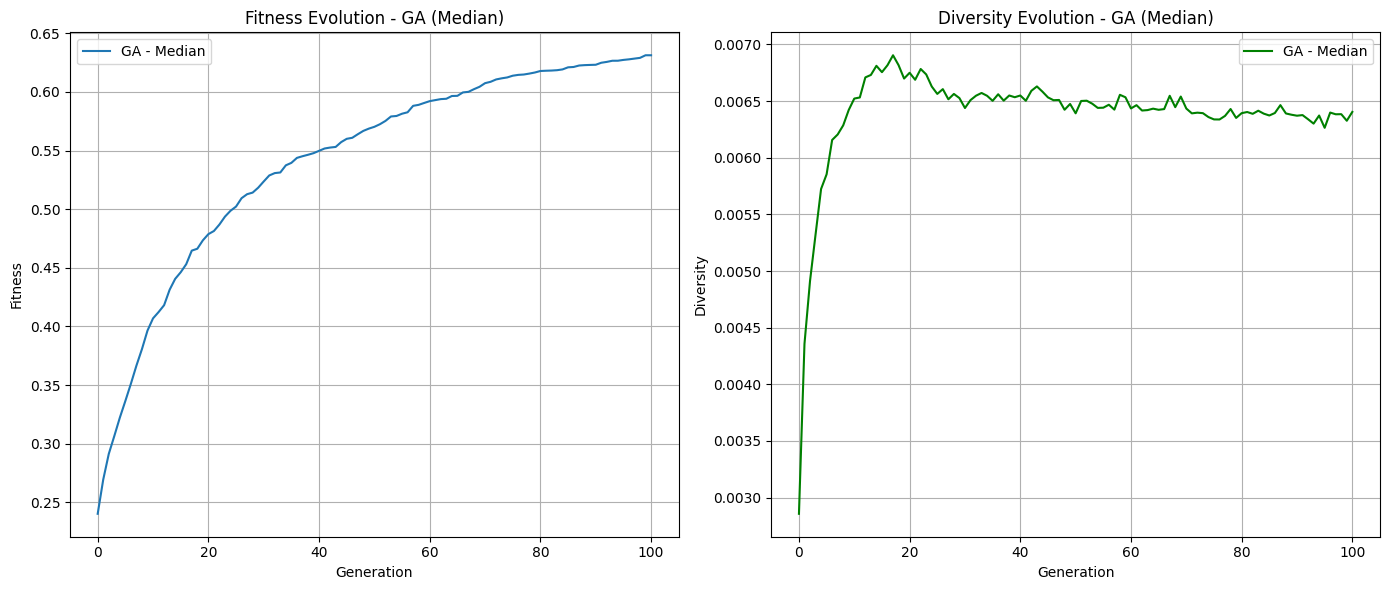

✅ Plotted fitness and diversity for GA - Median


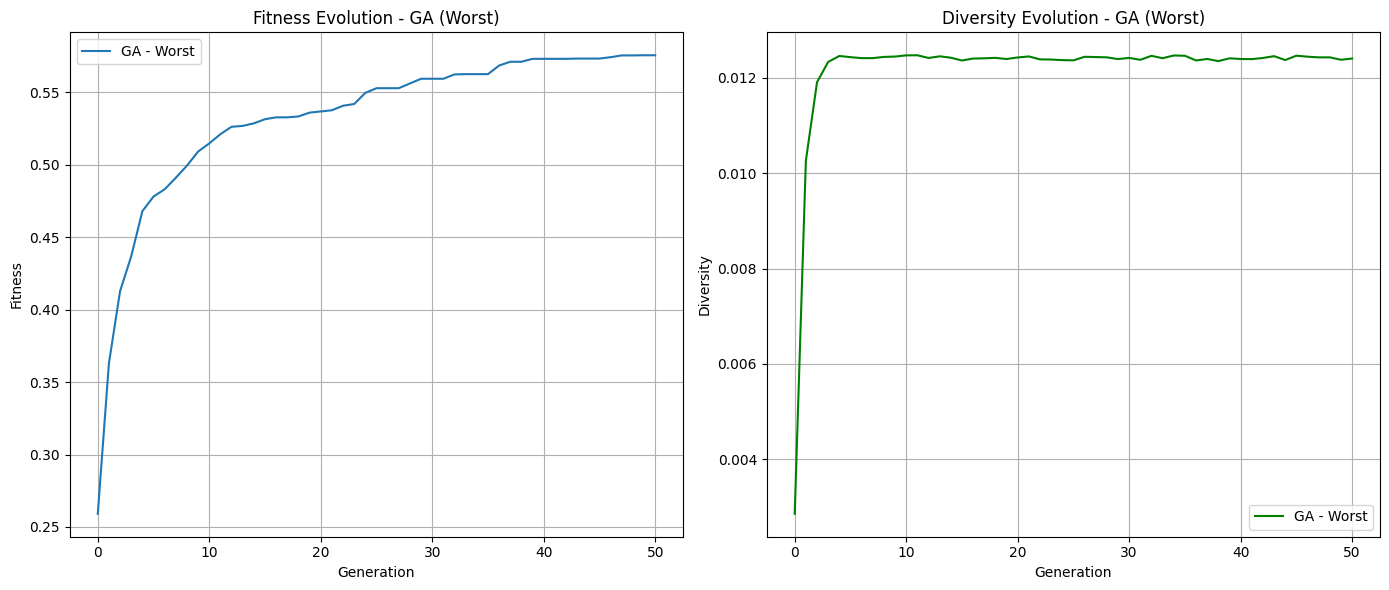

✅ Plotted fitness and diversity for GA - Worst


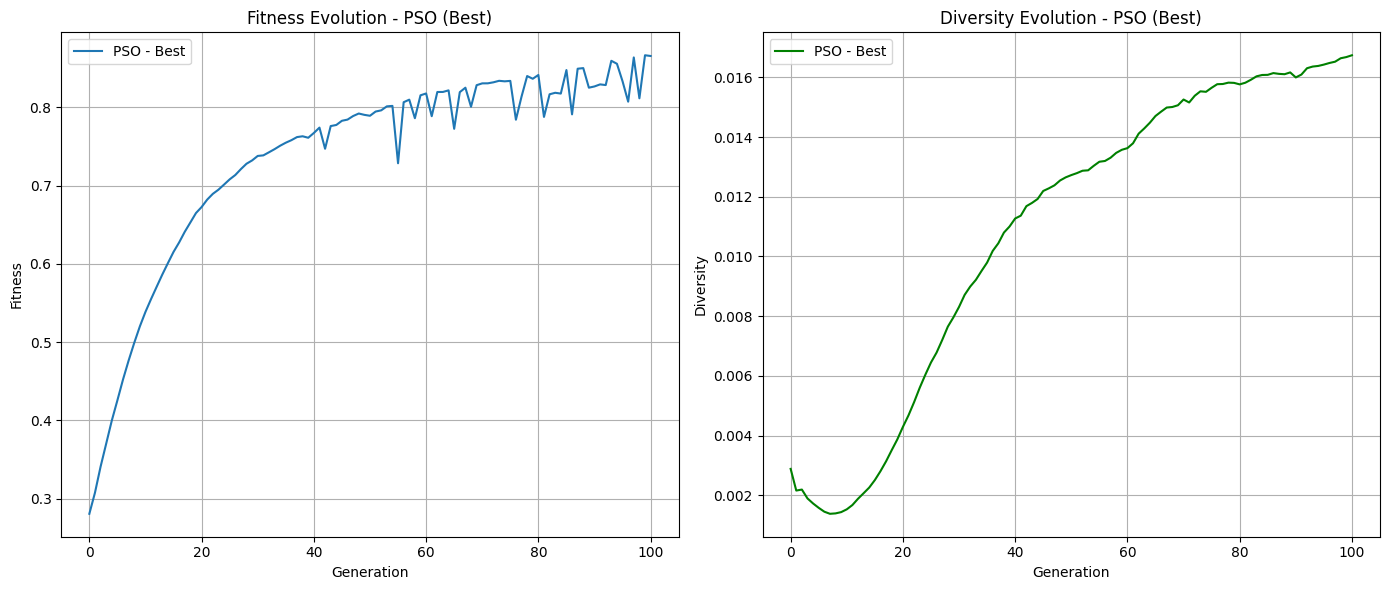

✅ Plotted fitness and diversity for PSO - Best


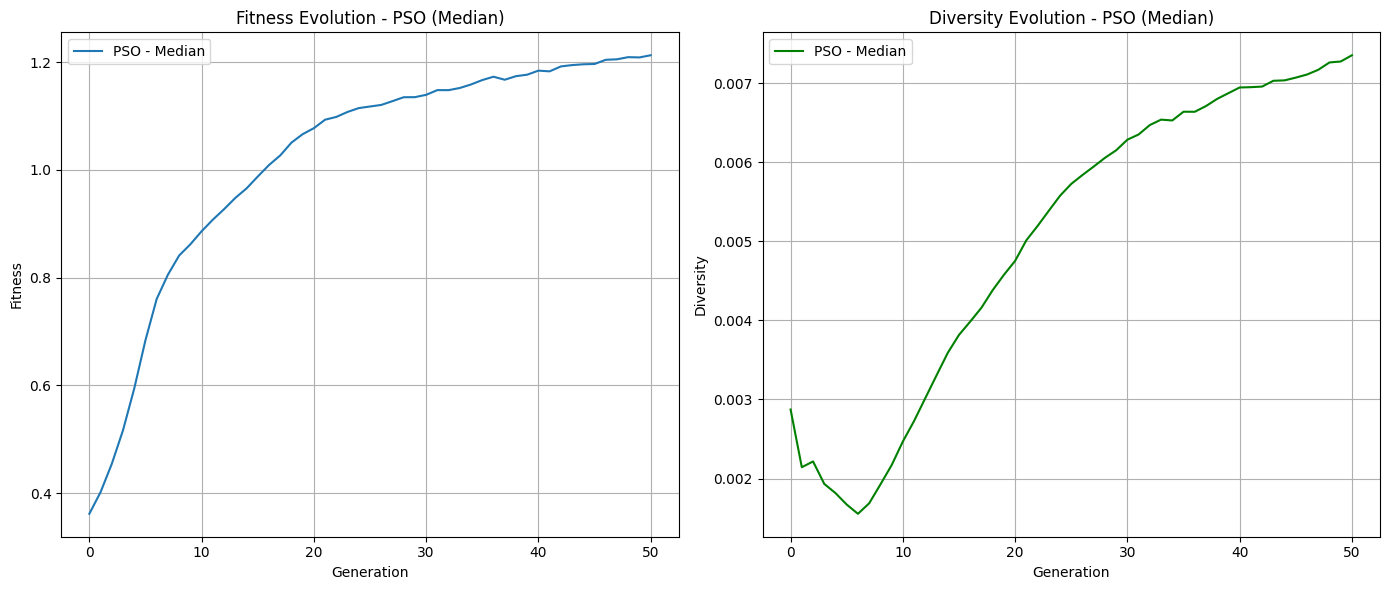

✅ Plotted fitness and diversity for PSO - Median


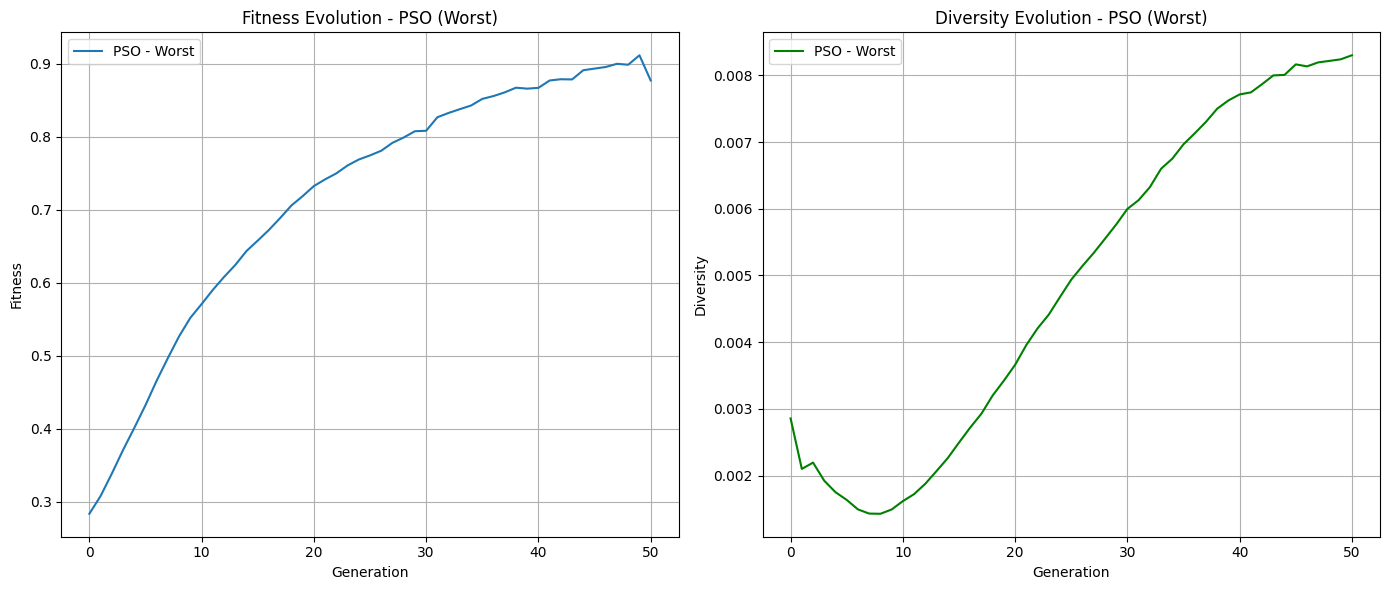

✅ Plotted fitness and diversity for PSO - Worst


In [6]:
# Plotting function for fitness and diversity
for algo in ["ga", "pso"]:
    for quality in ["best", "median", "worst"]:
        plot_fitness_diversity(
            final_results_df,
            get_results_path,
            generate_base_filename,
            algo,
            quality,
            correlation_level
        )

### Comparison of Best Fitness and Diversity between GA and PSO

- Compare the best fitness and diversity evolution between GA and PSO
- Helps in understanding which algorithm converges faster and maintains diversity

In [7]:
# Run the comparison function
compare_best_fitness_diversity(selected_configs, get_results_path, generate_base_filename)

❌ Error during comparison plotting: list indices must be integers or slices, not str


### Final Fitness Distribution

- A box plot or violin plot showing the distribution of final fitness values for each algorithm
- Visualize the variability in performance

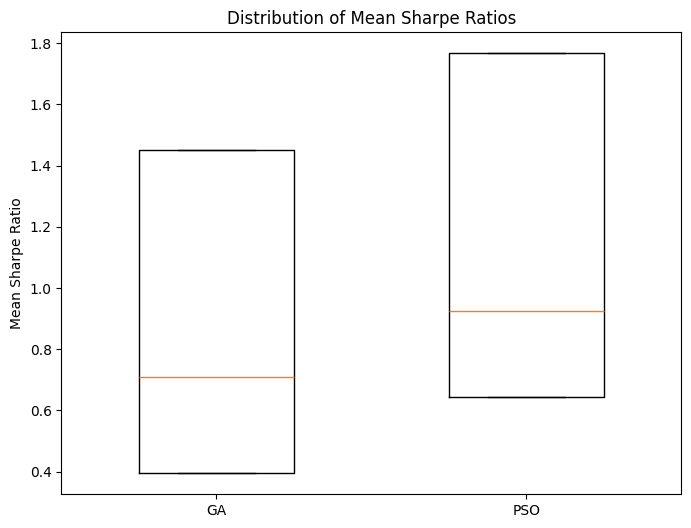

In [8]:
plot_fitness_distribution(final_results_df)

### Time taken per run

- A bar plot or box plot to show the time taken for each configuration
- Compare time taken between GA and PSO

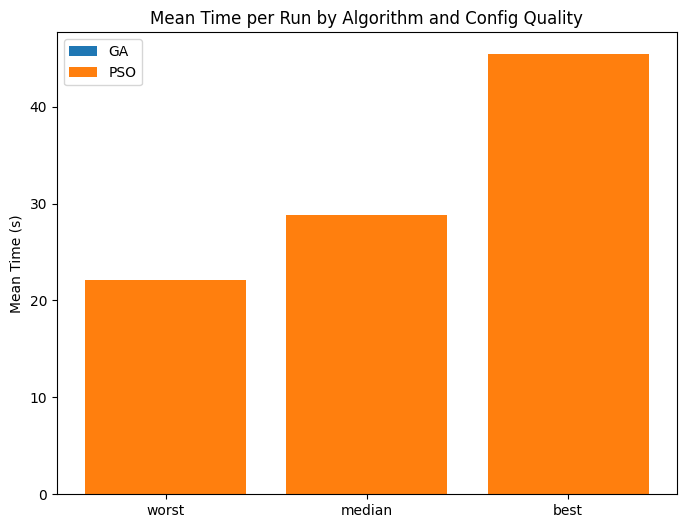

In [9]:
plot_time_per_run(final_results_df)

### Fitness vs. Time Tradeoff

- A scatter plot comparing the mean fitness vs. mean time taken
- Each point represents a different configuration

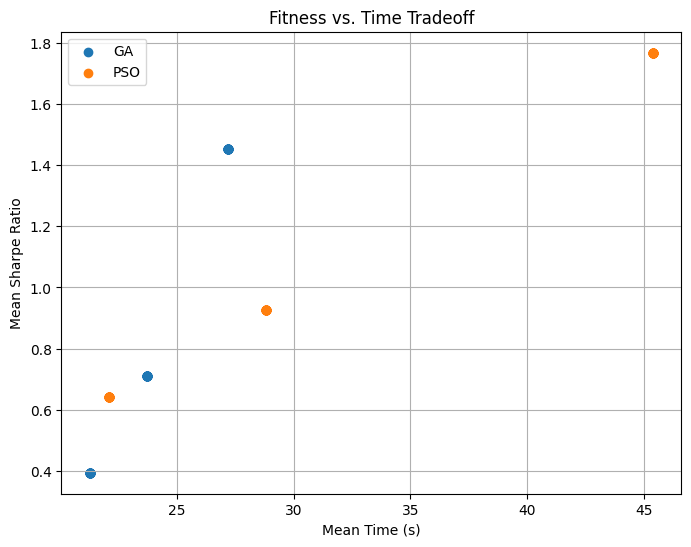

In [10]:
plot_fitness_vs_time(final_results_df)